In [37]:
from textblob import TextBlob 
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string

from wordcloud import WordCloud,STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# Authentication
consumerKey = ""
consumerSecret = ""
accessToken = ""
accessTokenSecret = ""
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [12]:
 nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...


True

In [13]:
#Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)
keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))
tweets = tweepy.Cursor(api.search_tweets, q=keyword).items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
for tweet in tweets:
 
 #print(tweet.text)
 tweet_list.append(tweet.text)
 analysis = TextBlob(tweet.text)
 score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 comp = score['compound']
 polarity += analysis.sentiment.polarity
 
 if neg > pos:
   negative_list.append(tweet.text)
   negative += 1
 elif pos > neg:
   positive_list.append(tweet.text)
   positive += 1
 
 elif pos == neg:
   neutral_list.append(tweet.text)
   neutral += 1
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

Please enter keyword or hashtag to search: covid19 travel
Please enter how many tweets to analyze: 100


In [14]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  100
positive number:  33
negative number:  33
neutral number:  34


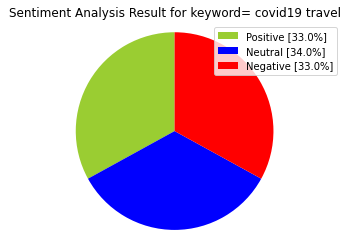

In [15]:
#Creating PieCart
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword= "+keyword+"" )
plt.axis("equal")
plt.show()

In [16]:
tweet_list

,0
0,"RT @WIONews: China’s ""zero Covid"" policy aims ..."
1,RT @news18dotcom: India’s #Grammy winner Ricky...
2,"China’s ""zero Covid"" policy aims to eliminate ..."
3,RT @RoslynByfield: Is Martha's sympathy for th...
4,RT @RoslynByfield: Is Martha's sympathy for th...
...,...
95,RT @Voiceof07314490: @supernova_11_11 Travel r...
96,KEEP DREAMING! We will travel again...\n\n#cov...
97,Fyi: The White House launched a one-stop-shop...
98,"Yeah, @JoeBiden and @CDCGov follow evidence an..."


In [17]:
tweet_list.drop_duplicates(inplace = True)

In [25]:
#Cleaning Text (RT, Punctuation etc)
#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub("RT @\w+: "," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,0,text
0,"RT @WIONews: China’s ""zero Covid"" policy aims ...",china s zero covid policy aims to eliminate...
1,RT @news18dotcom: India’s #Grammy winner Ricky...,india s grammy winner ricky kej in an ...
2,"China’s ""zero Covid"" policy aims to eliminate ...",china s zero covid policy aims to eliminate ...
3,RT @RoslynByfield: Is Martha's sympathy for th...,is martha s sympathy for the travel industry...
5,Il 20 dicembre 2021 la #Commissione europea ha...,il 20 dicembre 2021 la commissione europea ha...
6,#NEWS: Strong appetite for #travel in Europe t...,news strong appetite for travel in europe t...
7,La #Commissione si è finora assicurata fino a ...,la commissione si finora assicurata fino a ...
8,RT @FarmSailing: [U.S. MISSION CHINA STATEMENT...,u s mission china statement on travel advis...
10,RT @PolicyLabCHOP: COVID-LAB UPDATE: \n\nOur t...,covid lab update our team continues to mon...
11,Is Martha's sympathy for the #travel industry ...,is martha s sympathy for the travel industry ...


In [27]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
 score = SentimentIntensityAnalyzer().polarity_scores(row)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 comp = score['compound']
 if neg > pos:
   tw_list.loc[index, 'sentiment'] = "negative"
 elif pos > neg:
   tw_list.loc[index, 'sentiment'] = "positive"
 else:
   tw_list.loc[index, 'sentiment'] = "neutral"
 tw_list.loc[index, 'neg'] = neg
 tw_list.loc[index, 'neu'] = neu
 tw_list.loc[index, 'pos'] = pos
 tw_list.loc[index, 'compound'] = comp
tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,"RT @WIONews: China’s ""zero Covid"" policy aims ...",china s zero covid policy aims to eliminate...,0.000000,0.000000,negative,0.086,0.914,0.000,-0.1280
1,RT @news18dotcom: India’s #Grammy winner Ricky...,india s grammy winner ricky kej in an ...,0.000000,0.000000,positive,0.000,0.710,0.290,0.6486
2,"China’s ""zero Covid"" policy aims to eliminate ...",china s zero covid policy aims to eliminate ...,0.000000,0.000000,negative,0.205,0.795,0.000,-0.3818
3,RT @RoslynByfield: Is Martha's sympathy for th...,is martha s sympathy for the travel industry...,-0.155556,0.288889,positive,0.087,0.714,0.198,0.4215
5,Il 20 dicembre 2021 la #Commissione europea ha...,il 20 dicembre 2021 la commissione europea ha...,0.000000,0.000000,positive,0.000,0.862,0.138,0.3400
6,#NEWS: Strong appetite for #travel in Europe t...,news strong appetite for travel in europe t...,0.433333,0.733333,positive,0.000,0.676,0.324,0.7351
7,La #Commissione si è finora assicurata fino a ...,la commissione si finora assicurata fino a ...,0.000000,0.000000,negative,0.126,0.874,0.000,-0.3182
8,RT @FarmSailing: [U.S. MISSION CHINA STATEMENT...,u s mission china statement on travel advis...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
10,RT @PolicyLabCHOP: COVID-LAB UPDATE: \n\nOur t...,covid lab update our team continues to mon...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
11,Is Martha's sympathy for the #travel industry ...,is martha s sympathy for the travel industry ...,-0.155556,0.288889,positive,0.000,0.773,0.227,0.6124


In [28]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [31]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
positive,32,44.44
neutral,27,37.50
negative,13,18.06


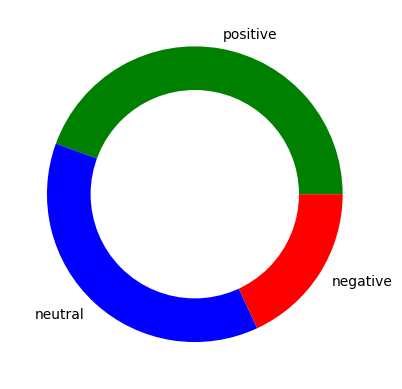

In [33]:
# create data for Pie Chart
pc = count_values_in_column(tw_list,"sentiment")
names= pc.index
size=pc["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [46]:
#Function to Create Wordcloud
def create_wordcloud(text):
 #mask = np.array(Image.open("cloud.png"))
 stopwords = set(STOPWORDS)
 wc = WordCloud(background_color="white",
 max_words=3000,
 stopwords=stopwords,
 repeat=True)
 wc.generate(str(text))
 wc.to_file("wc.png")
 print("Word Cloud Saved Successfully")
 path="wc.png"
 display(Image.open(path))

Word Cloud Saved Successfully


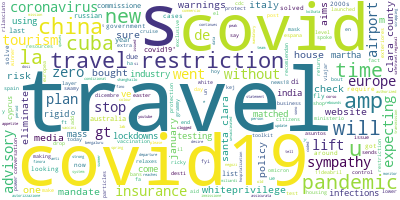

In [47]:
create_wordcloud(tw_list["text"].values)

Word Cloud Saved Successfully


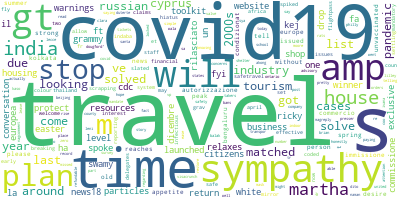

In [49]:
create_wordcloud(tw_list_positive["text"].values)

Word Cloud Saved Successfully


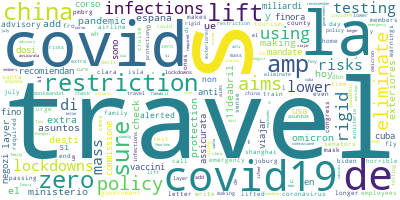

In [50]:
create_wordcloud(tw_list_negative["text"].values)

In [51]:
#Calculating tweet’s lenght and word count
tw_list['text_len'] = tw_list['text'].astype(str).apply(len)
tw_list['text_word_count'] = tw_list['text'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(tw_list.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,115.31
neutral,99.81
positive,112.03


In [52]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,18.85
neutral,13.37
positive,18.50


In [53]:
#Removing Punctuation
def remove_punct(text):
 text = "".join([char for char in text if char not in string.punctuation])
 text = re.sub('[0–9]+', '', text)
 return text
tw_list['punct'] = tw_list['text'].apply(lambda x: remove_punct(x))
#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
tw_list['tokenized'] = tw_list['punct'].apply(lambda x: tokenization(x.lower()))
#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))
#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
tw_list.head()

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count,punct,tokenized,nonstop,stemmed
0,"RT @WIONews: China’s ""zero Covid"" policy aims ...",china s zero covid policy aims to eliminate...,0.000000,0.000000,negative,0.086,0.914,0.000,-0.1280,128,18,china s zero covid policy aims to eliminate...,"[, china, s, zero, covid, policy, aims, to, el...","[, china, zero, covid, policy, aims, eliminate...","[, china, zero, covid, polici, aim, elimin, in..."
1,RT @news18dotcom: India’s #Grammy winner Ricky...,india s grammy winner ricky kej in an ...,0.000000,0.000000,positive,0.000,0.710,0.290,0.6486,108,17,india s grammy winner ricky kej in an ...,"[, india, s, grammy, winner, ricky, kej, in, a...","[, india, grammy, winner, ricky, kej, exclusiv...","[, india, grammi, winner, ricki, kej, exclus, ..."
2,"China’s ""zero Covid"" policy aims to eliminate ...",china s zero covid policy aims to eliminate ...,0.000000,0.000000,negative,0.205,0.795,0.000,-0.3818,118,17,china s zero covid policy aims to eliminate ...,"[china, s, zero, covid, policy, aims, to, elim...","[china, zero, covid, policy, aims, eliminate, ...","[china, zero, covid, polici, aim, elimin, infe..."
3,RT @RoslynByfield: Is Martha's sympathy for th...,is martha s sympathy for the travel industry...,-0.155556,0.288889,positive,0.087,0.714,0.198,0.4215,122,22,is martha s sympathy for the travel industry...,"[, is, martha, s, sympathy, for, the, travel, ...","[, martha, sympathy, travel, industry, matched...","[, martha, sympathi, travel, industri, match, ..."
5,Il 20 dicembre 2021 la #Commissione europea ha...,il 20 dicembre 2021 la commissione europea ha...,0.000000,0.000000,positive,0.000,0.862,0.138,0.3400,118,16,il 2 dicembre 221 la commissione europea ha r...,"[il, 2, dicembre, 221, la, commissione, europe...","[il, 2, dicembre, 221, la, commissione, europe...","[il, 2, dicembr, 221, la, commission, europea,..."


In [54]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tw_list['text'])
print("{} Number of reviews has {} words".format(countVector.shape[0], countVector.shape[1]))
#print(countVectorizer.get_feature_names())

count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

72 Number of reviews has 452 words


C:\Users\HP\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,,abl,abstain,actual,add,advisori,africa,ahead,aid,aim,...,winner,without,worker,write,ye,yeah,year,youtub,zealand,zero
0,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
travel,50
covid,46
restrict,9
amp,7
pandem,6
time,6
china,6
lift,5
la,5
insur,5


In [57]:
'''Building n gram model to predict most probably word that might follow this sequence.'''
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
 vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
 bag_of_words = vec.transform(corpus)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
 return words_freq[:n]
#n2_bigram
n2_bigrams = get_top_n_gram(tw_list['text'],(2,2),20)
n2_bigrams

[('travel restrictions', 7),
 ('covid19 travel', 5),
 ('travel insurance', 4),
 ('travel advisory', 3),
 ('expecting whiteprivilege', 3),
 ('whiteprivilege media', 3),
 ('media went', 3),
 ('went cuba', 3),
 ('cuba january', 3),
 ('january bought', 3),
 ('bought travel', 3),
 ('santa clara', 3),
 ('clara county', 3),
 ('travel warnings', 3),
 ('china zero', 2),
 ('zero covid', 2),
 ('covid policy', 2),
 ('policy aims', 2),
 ('aims eliminate', 2),
 ('eliminate infections', 2)]

In [58]:


n3_bigrams = get_top_n_gram(tw_list['text'],(3,),20)
n3_bigrams

[('expecting whiteprivilege media', 3),
 ('whiteprivilege media went', 3),
 ('media went cuba', 3),
 ('went cuba january', 3),
 ('cuba january bought', 3),
 ('january bought travel', 3),
 ('bought travel insurance', 3),
 ('santa clara county', 3),
 ('china zero covid', 2),
 ('zero covid policy', 2),
 ('covid policy aims', 2),
 ('policy aims eliminate', 2),
 ('aims eliminate infections', 2),
 ('eliminate infections using', 2),
 ('infections using rigid', 2),
 ('using rigid lockdowns', 2),
 ('rigid lockdowns mass', 2),
 ('lockdowns mass testing', 2),
 ('mass testing travel', 2),
 ('martha sympathy travel', 2)]